In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
data = pd.read_csv('/kaggle/input/weather/seattle-weather.csv')
data

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [3]:
data.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [5]:
data.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [7]:
data.shape

(1461, 6)

In [11]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True) 
for i in range(2012, 2016):  
    year_count = data.index.year.tolist().count(i) 
    print(i, year_count)

2012 366
2013 365
2014 365
2015 365


In [12]:
def plot_graph(figsize,values,column_name):
    plt.figure(figsize = figsize)
    values.plot()
    plt.xlabel("Years")
    plt.ylabel(column_name)
    plt.title(f"Variation of {column_name} ")
    plt.show()

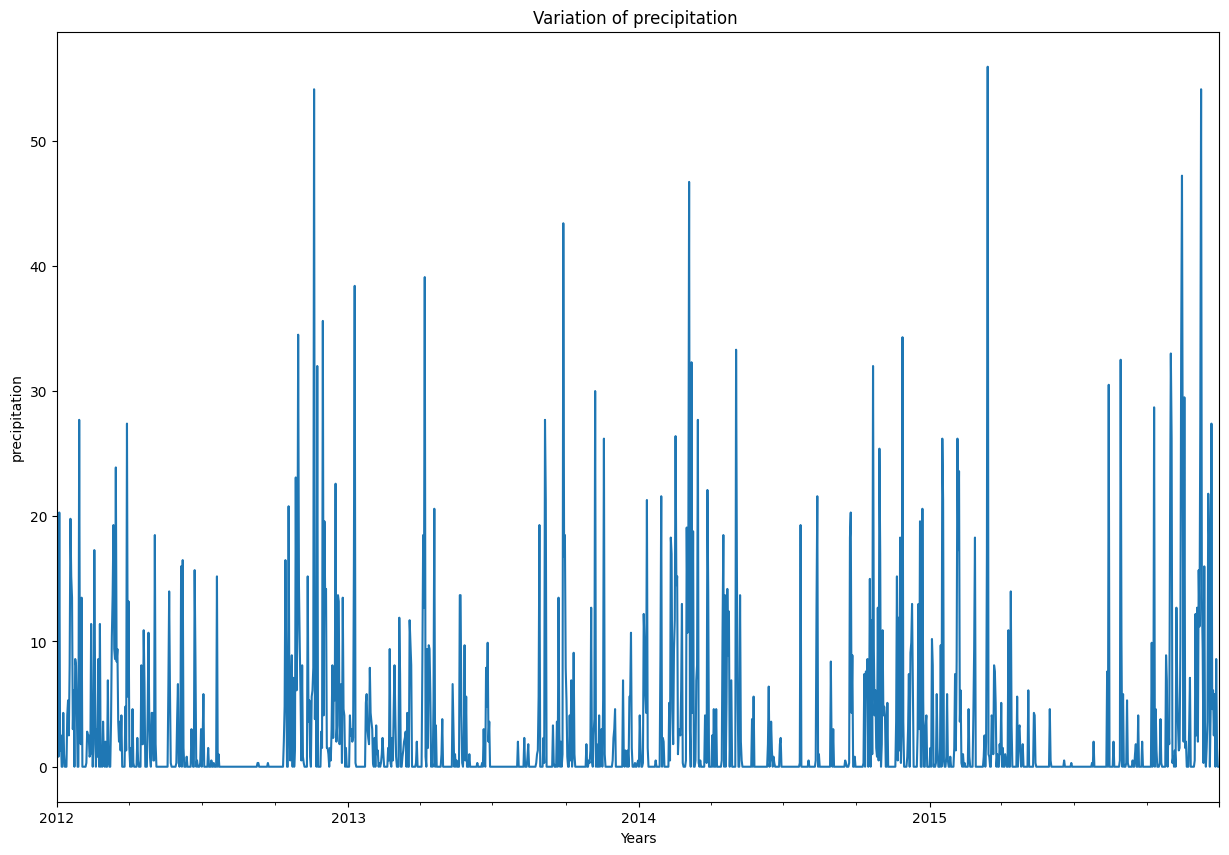

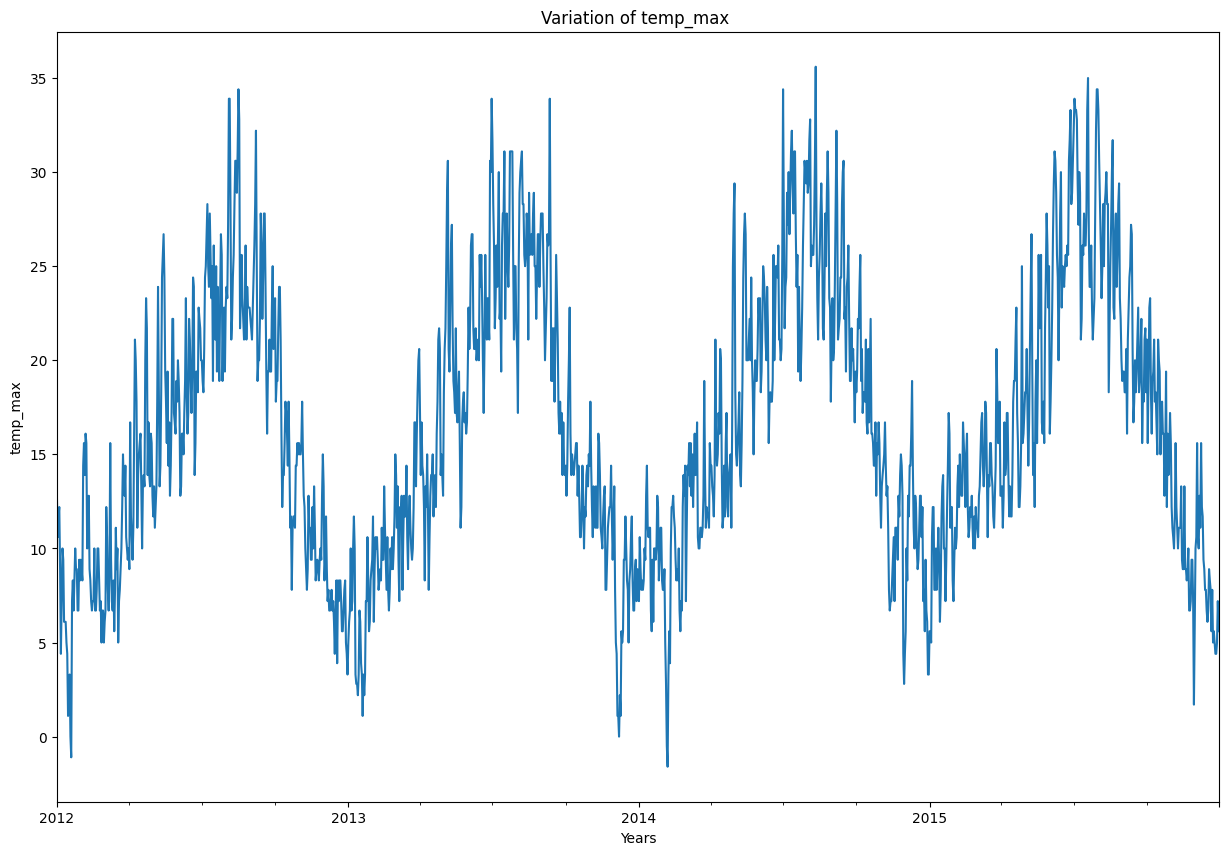

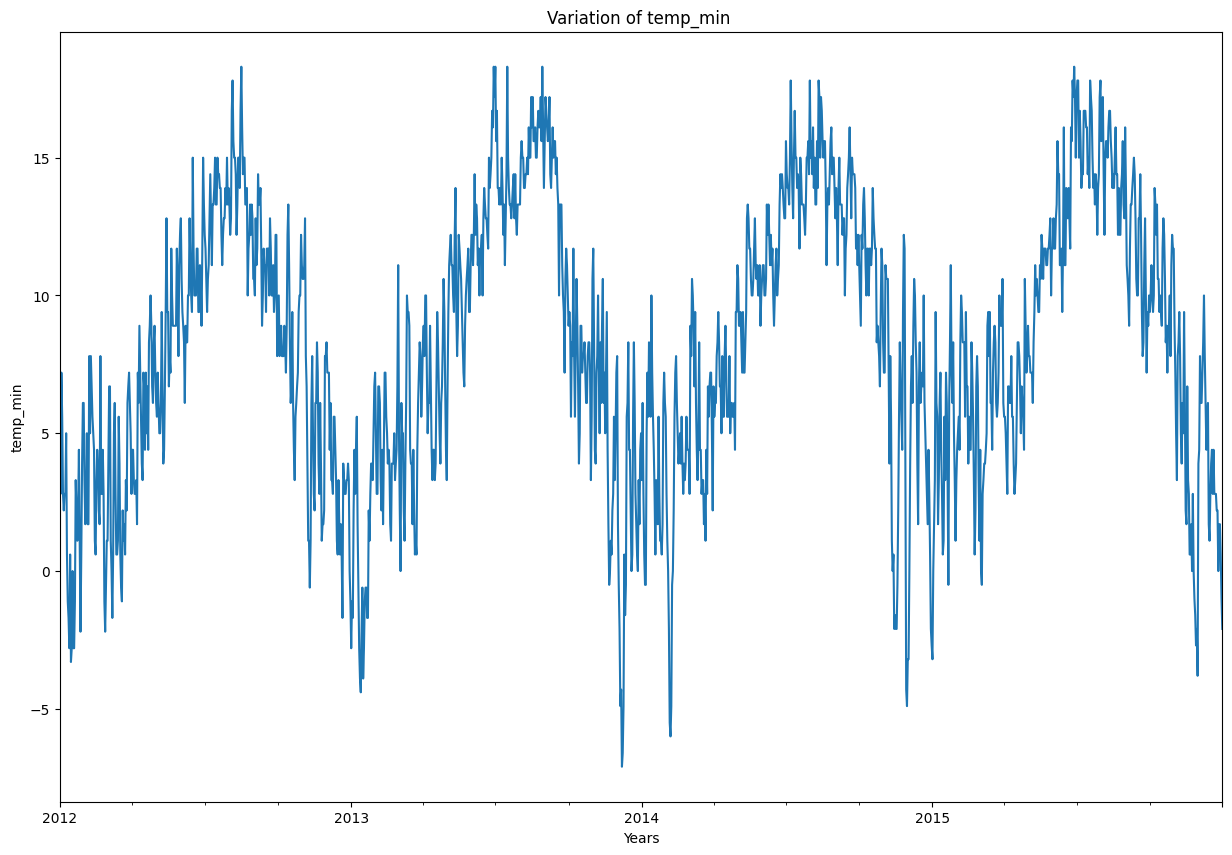

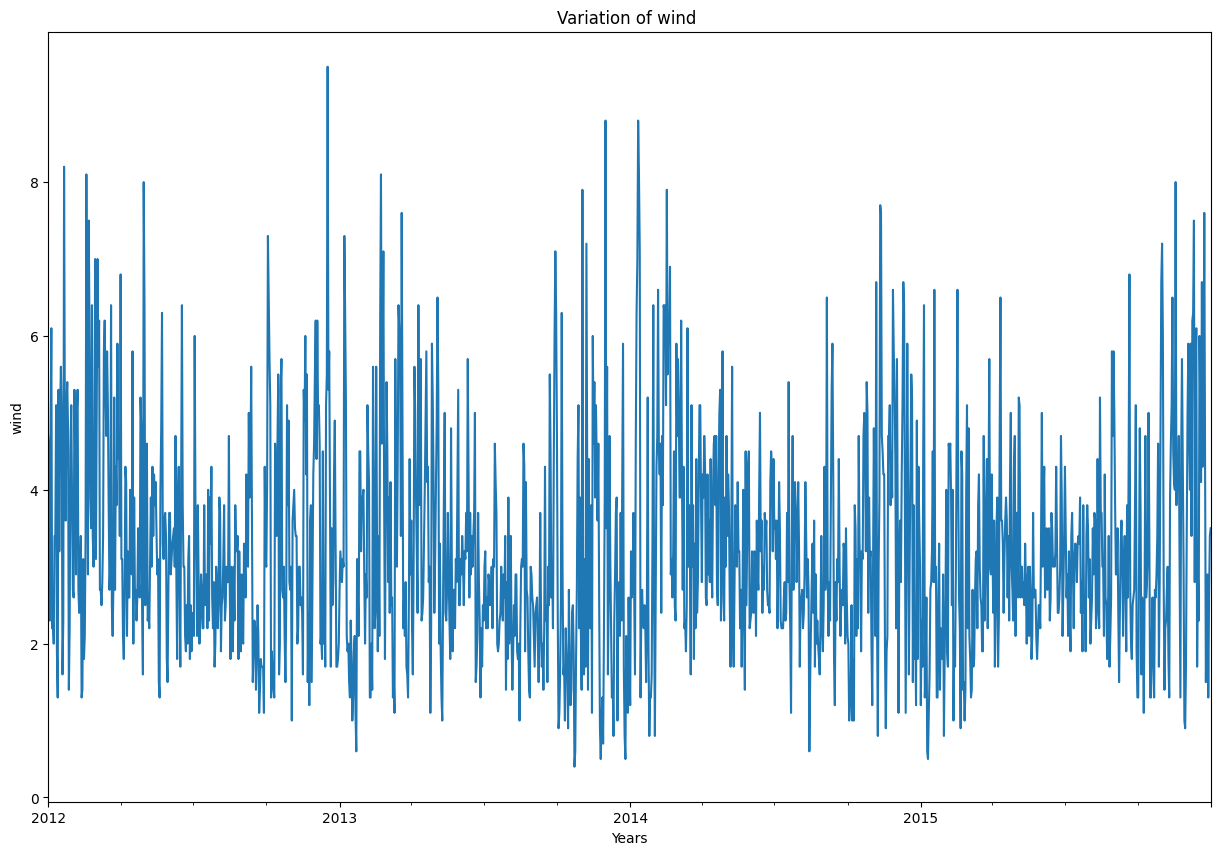

In [15]:
for columns in data.columns.drop(['weather']):
    plot_graph((15,10),data[columns],columns)

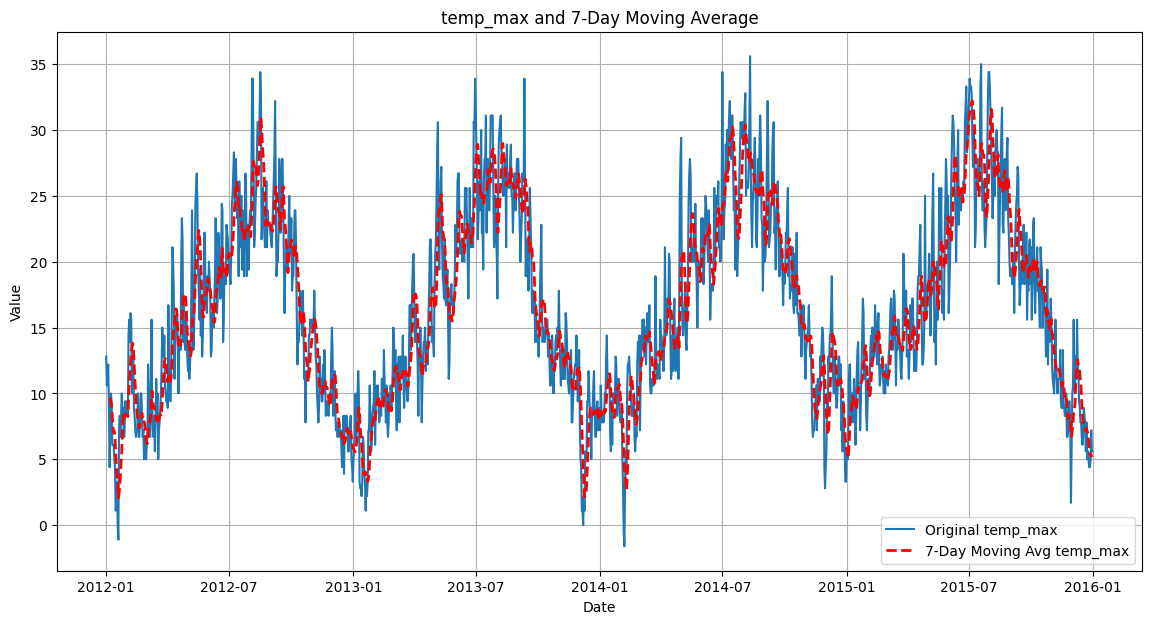

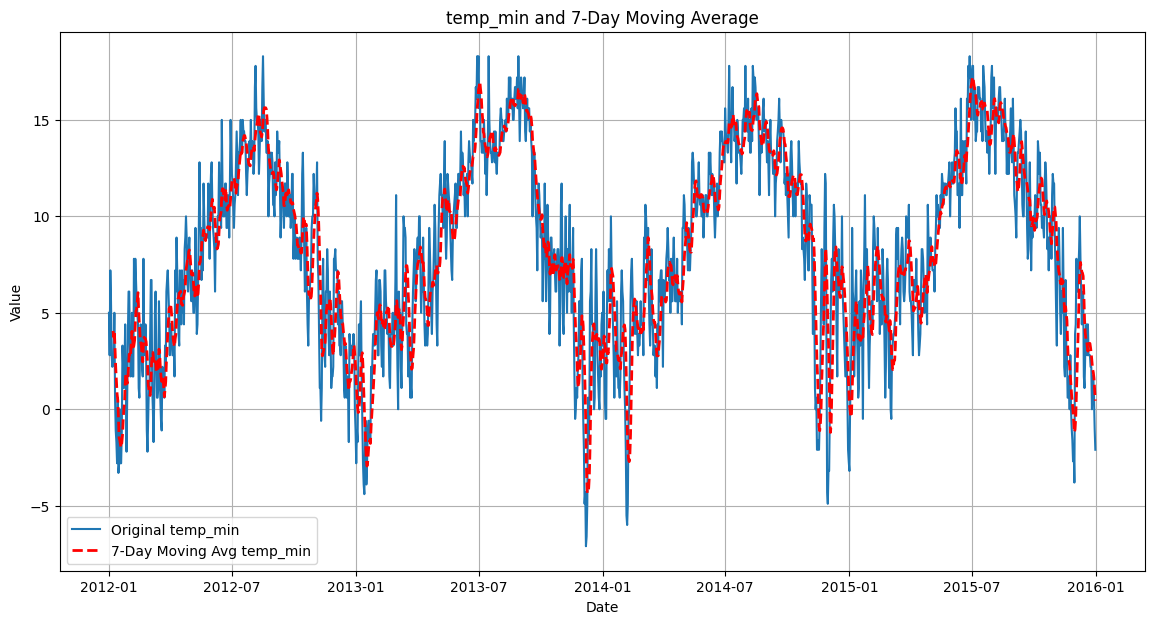

In [34]:
moving_avg_data = data[['temp_max', 'temp_min']].rolling(window=7).mean()

for column in moving_avg_data.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data[column], label=f'Original {column}')
    plt.plot(moving_avg_data.index, moving_avg_data[column], label=f'7-Day Moving Avg {column}', linestyle='--', linewidth=2, color='red')
    plt.title(f'{column} and 7-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [24]:
temp_max = data[['temp_max']]
temp_min = data[['temp_min']]

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

temp_max_scaled = scaler.fit_transform(temp_max)
temp_min_scaled = scaler.fit_transform(temp_min)

temp_max_scaled = pd.DataFrame(temp_max_scaled, columns=['temp_max_scaled'])
temp_min_scaled = pd.DataFrame(temp_min_scaled, columns=['temp_min_scaled'])

In [26]:
def create_sequences(data, time_steps=7):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0]) 
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_max, y_max = create_sequences(temp_max_scaled.values, time_steps=50)
X_min, y_min = create_sequences(temp_min_scaled.values, time_steps=50)

X_max = X_max.reshape(X_max.shape[0], X_max.shape[1], 1)
X_min = X_min.reshape(X_min.shape[0], X_min.shape[1], 1)

print(X_max.shape, y_max.shape)
print(X_min.shape, y_min.shape)

(1411, 50, 1) (1411,)
(1411, 50, 1) (1411,)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
    
model_max = build_lstm((X_max.shape[1], 1))
model_min = build_lstm((X_min.shape[1], 1))

model_max.summary()
model_min.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history1 = model_max.fit(X_max, y_max, epochs=100, batch_size=32)

history2 = model_min.fit(X_min, y_min, epochs=100, batch_size=32)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0059
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0053
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0055
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0055
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0054
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0055
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0053
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0051
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0053
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0055
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0052
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0053
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0051
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - lo

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


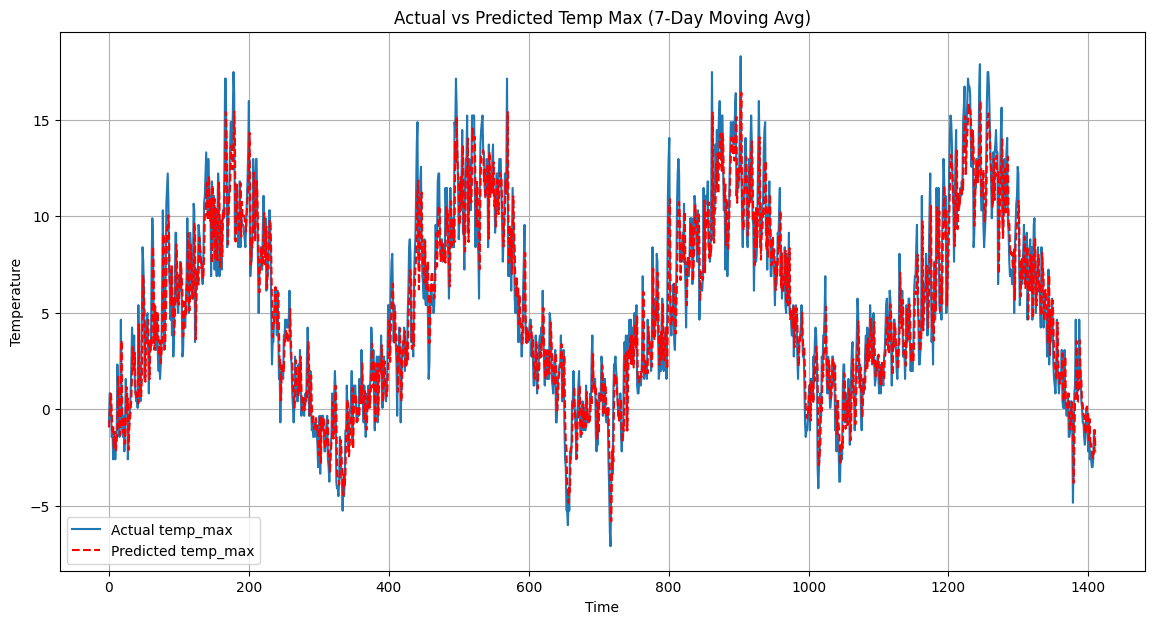

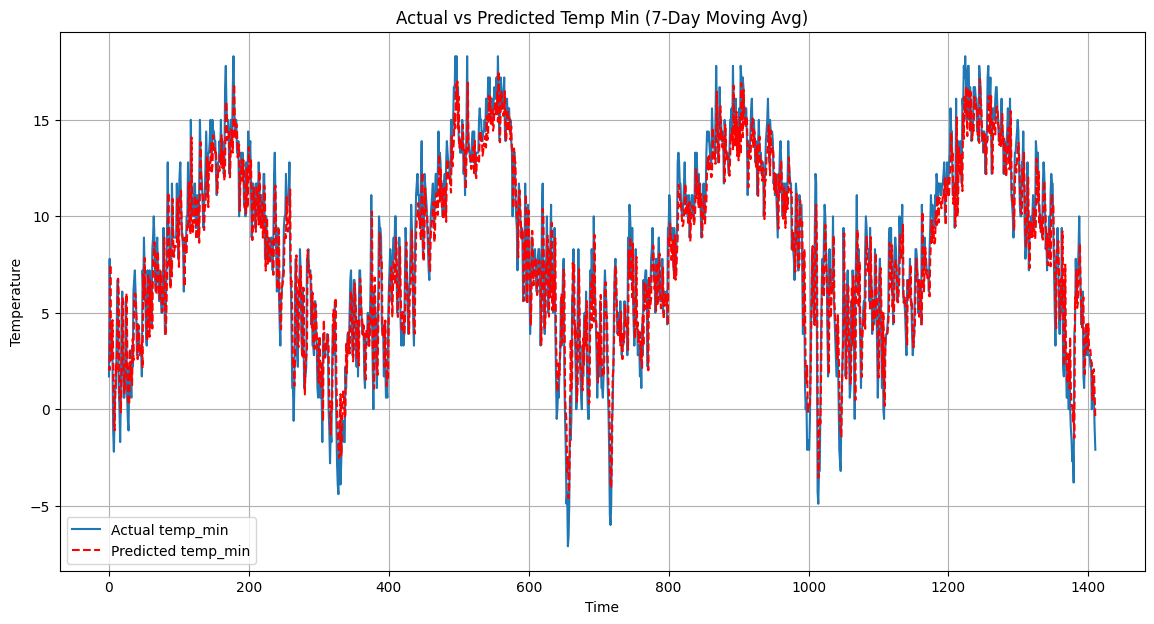

In [31]:
# Predicting on the scaled data
y_pred_max = model_max.predict(X_max)
y_pred_min = model_min.predict(X_min)

# Inverse scaling the predictions and actual values
y_pred_max = scaler.inverse_transform(y_pred_max)
y_pred_min = scaler.inverse_transform(y_pred_min)

# Rescale the original data back
y_true_max = scaler.inverse_transform(y_max.reshape(-1, 1))
y_true_min = scaler.inverse_transform(y_min.reshape(-1, 1))

# Plotting the results for temp_max
plt.figure(figsize=(14, 7))
plt.plot(y_true_max, label='Actual temp_max')
plt.plot(y_pred_max, label='Predicted temp_max', linestyle='--', color='red')
plt.title('Actual vs Predicted Temp Max (7-Day Moving Avg)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the results for temp_min
plt.figure(figsize=(14, 7))
plt.plot(y_true_min, label='Actual temp_min')
plt.plot(y_pred_min, label='Predicted temp_min', linestyle='--', color='red')
plt.title('Actual vs Predicted Temp Min (7-Day Moving Avg)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()


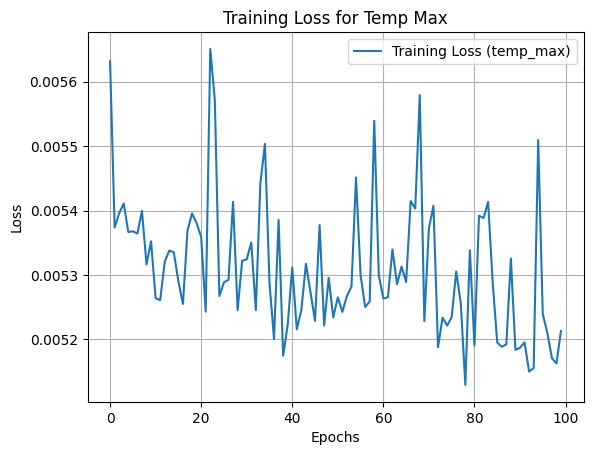

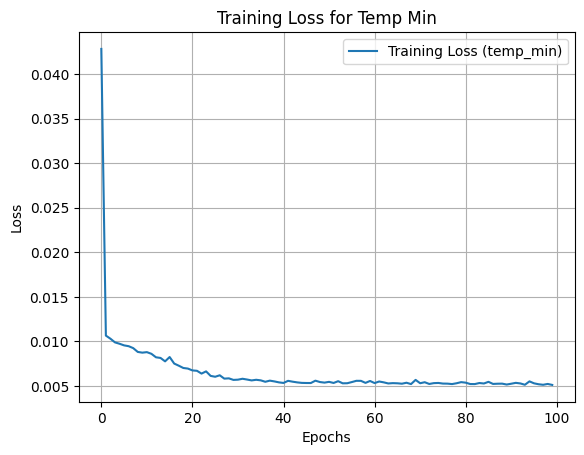

In [32]:
import matplotlib.pyplot as plt

# Plot the training loss for temp_max model
plt.plot(history1.history['loss'], label='Training Loss (temp_max)')
plt.title('Training Loss for Temp Max')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training loss for temp_min model
plt.plot(history2.history['loss'], label='Training Loss (temp_min)')
plt.title('Training Loss for Temp Min')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predicting on the test set (in your case, we can use the training data itself for simplicity here)
y_pred_max = model_max.predict(X_max)
y_pred_min = model_min.predict(X_min)

# Inverse scaling the predictions and actual values
y_pred_max = scaler.inverse_transform(y_pred_max)
y_pred_min = scaler.inverse_transform(y_pred_min)

y_true_max = scaler.inverse_transform(y_max.reshape(-1, 1))
y_true_min = scaler.inverse_transform(y_min.reshape(-1, 1))

# Calculate MSE and RMSE for temp_max
mse_max = mean_squared_error(y_true_max, y_pred_max)
rmse_max = np.sqrt(mse_max)

# Calculate MSE and RMSE for temp_min
mse_min = mean_squared_error(y_true_min, y_pred_min)
rmse_min = np.sqrt(mse_min)

# Print the results
print(f'MSE for Temp Max: {mse_max}')
print(f'RMSE for Temp Max: {rmse_max}')

print(f'MSE for Temp Min: {mse_min}')
print(f'RMSE for Temp Min: {rmse_min}')


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MSE for Temp Max: 3.285365294771295
RMSE for Temp Max: 1.812557666605754
MSE for Temp Min: 3.4211651360310253
RMSE for Temp Min: 1.8496391907696552


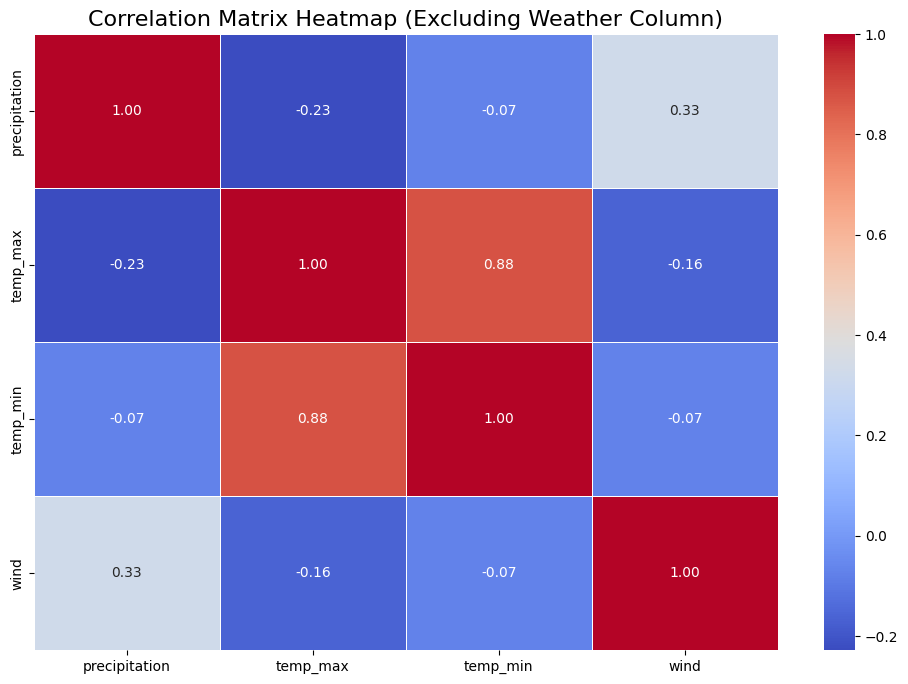

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `data` is your DataFrame
# Drop the 'weather' column from the DataFrame
data_without_weather = data.drop(columns=['weather'])

# Calculate the correlation matrix
corr = data_without_weather.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title for the heatmap
plt.title('Correlation Matrix Heatmap (Excluding Weather Column)', fontsize=16)

# Display the plot
plt.show()
